# Training a simple linear classification NN with manual pytorch autograd

In [151]:
!jupytext --to markdown "manual_SGD_with_torch_autograd.ipynb"

[jupytext] Reading manual_SGD_with_torch_autograd.ipynb
[jupytext] Writing manual_SGD_with_torch_autograd.md (destination file replaced)


In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import numpy as np

In [122]:
def plot_points(X, y):
    positive = X[np.argwhere(y==1)]
    negative = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in negative], [s[0][1] for s in negative], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in positive], [s[0][1] for s in positive], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

In [123]:
# generate the data
n=100
xy = np.random.randn(n,2)
xy[:n//2,0] = xy[:n//2,0]/5+0.5
xy[:n//2,1] = xy[:n//2,1]/7+0.3
xy[n//2:,0] = xy[n//2:,0]/5+1
xy[n//2:,1] = xy[n//2:,1]/9+0.3
target = n//2*[1] + n//2*[0]

rotation_matrix = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                   [np.sin(np.pi/4), np.cos(np.pi/4)]])
xy = np.matmul(xy, rotation_matrix.T)

data = DataFrame(xy, columns=['x','y'])
data['target'] = target
data.head()

,x,y,target
0,0.272120,0.534572,1
1,-0.088770,0.618814,1
2,0.258011,0.614532,1
3,0.397269,0.433527,1
4,0.158142,0.301420,1


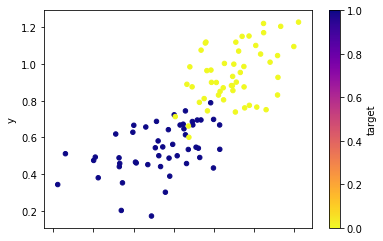

In [124]:
data.plot(kind='scatter', x='x', y='y', c = 'target', colormap = 'plasma_r')
plt.show()

In [125]:
class PointsDataset(Dataset):
    def __init__(self, data, transform = None):
        self.points = torch.as_tensor(data[:,:2], dtype=torch.float) # coordinates x and y
        self.labels = torch.as_tensor(data[:,2], dtype=torch.float) # lablels
        self.len = len(data)
        
    def __getitem__(self, index):
        return self.points[index], self.labels[index]
    def __len__(self):
        return self.len

In [126]:
points = PointsDataset(data.values)

In [127]:
points_loader = DataLoader(points, batch_size=20, shuffle=True)

In [128]:
# display the minibatch data 
iter(points_loader).next()[0]

tensor([[ 3.2729e-01,  7.9161e-01],
        [ 6.4692e-01,  1.1715e+00],
        [ 2.7288e-01,  6.6241e-01],
        [ 8.2046e-01,  1.2291e+00],
        [ 5.7588e-01,  7.7530e-01],
        [ 3.8738e-01,  9.0057e-01],
        [ 5.5257e-01,  7.6137e-01],
        [ 2.1694e-01,  5.0016e-01],
        [ 4.5178e-01,  1.0039e+00],
        [ 4.9277e-01,  9.3306e-01],
        [ 2.7212e-01,  5.3457e-01],
        [-3.3906e-01,  5.1143e-01],
        [ 1.7988e-01,  3.8888e-01],
        [ 5.3984e-01,  1.1514e+00],
        [ 1.0815e-01,  5.4379e-01],
        [ 1.2548e-01,  5.0049e-01],
        [ 1.1223e-03,  6.6646e-01],
        [ 7.9713e-01,  1.0961e+00],
        [ 1.7639e-01,  4.8743e-01],
        [-1.7585e-01,  3.8022e-01]])

In [129]:
class PointsNN(nn.Module):
    """
    logistic regression via one layer neural network
    gives out probability of positive class
    """
    def __init__(self):
        super(PointsNN, self).__init__()
        self.l1 = nn.Linear(2,1)
    def forward(self, x):
        x = self.l1(x)
        score = F.relu(x)
        out = torch.sigmoid(x)
        return out.squeeze() 

In [130]:
points_nn = PointsNN()

In [131]:
points_nn(iter(points_loader).next()[0])

tensor([0.6217, 0.7066, 0.6172, 0.7322, 0.6252, 0.6676, 0.7014, 0.6436, 0.6699,
        0.6131, 0.7026, 0.7069, 0.6983, 0.7481, 0.7544, 0.7226, 0.6184, 0.6514,
        0.6795, 0.7046], grad_fn=<SqueezeBackward0>)

In [132]:
def get_weights(net):
    """
    get y = m*x + b coefficients from the network
    """
    w1, w2 = net.l1.weight.data.numpy()[0]
    b = net.l1.bias.item()
    return -w1/w2, -b/w2

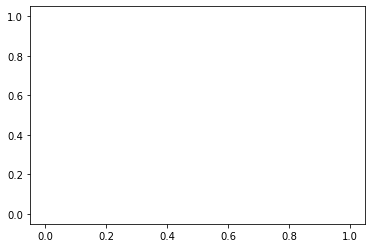

In [133]:
m, b = get_weights(points_nn)
display(m,b)

## Single step

In [134]:
lr = 0.1
criterion = nn.BCELoss()

In [135]:
points_batch, labels_batch = iter(points_loader).next()
points_batch, labels_batch

(tensor([[ 5.7424e-01,  1.1533e+00],
         [ 6.4692e-01,  1.1715e+00],
         [ 6.0733e-02,  6.5713e-01],
         [ 3.5103e-01,  8.1212e-01],
         [ 5.4871e-01,  9.8710e-01],
         [ 5.1102e-01,  9.0194e-01],
         [ 3.8738e-01,  9.0057e-01],
         [-1.9862e-01,  4.7476e-01],
         [ 2.9223e-01,  6.8702e-01],
         [ 1.1223e-03,  6.6646e-01],
         [ 5.0862e-01,  1.1198e+00],
         [-3.6143e-03,  6.2847e-01],
         [ 2.0731e-01,  7.1387e-01],
         [ 1.4516e-01,  5.4848e-01],
         [ 3.9727e-01,  4.3353e-01],
         [ 4.2233e-01,  8.3134e-01],
         [ 2.5801e-01,  6.1453e-01],
         [ 3.1684e-01,  6.9505e-01],
         [ 3.1072e-01,  5.4687e-01],
         [ 7.1617e-01,  1.0466e+00]]),
 tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
         1., 0.]))

In [136]:
out = points_nn(points_batch)
out

tensor([0.7397, 0.7460, 0.6514, 0.6897, 0.7215, 0.7102, 0.7017, 0.6102, 0.6718,
        0.6481, 0.7322, 0.6433, 0.6686, 0.6452, 0.6508, 0.6967, 0.6612, 0.6745,
        0.6574, 0.7382], grad_fn=<SqueezeBackward0>)

In [137]:
loss = criterion(out, labels_batch)
loss

tensor(0.8429, grad_fn=<BinaryCrossEntropyBackward>)

In [138]:
loss.backward()

In [139]:
points_nn.l1.weight.grad, points_nn.l1.bias.grad

(tensor([[0.1494, 0.2427]]), tensor([0.1829]))

In [140]:
with torch.no_grad():
    # update weights and biases
    points_nn.l1.weight.data -= lr*points_nn.l1.weight.grad
    # update the bias
    points_nn.l1.bias.data -= lr*points_nn.l1.bias.grad
    
    points_nn.l1.weight.grad.zero_()
    points_nn.l1.bias.grad.zero_()

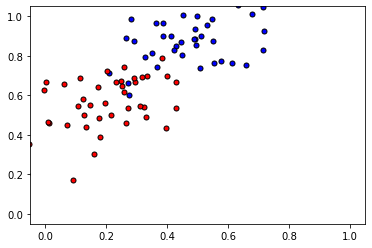

In [141]:
m, b = get_weights(points_nn)
display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

## Main training loop

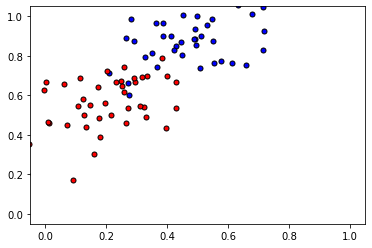

In [142]:
# reset the weights
#points_nn.l1.weight.data = torch.FloatTensor([[1,-1]])
#points_nn.l1.bias.data = torch.FloatTensor([0])
# display the picture visually
m, b = get_weights(points_nn)
display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

In [143]:
# number of batches in a loader, and points in one epoch/dataset
len(points_loader), len(points), len(points_loader.dataset)

(5, 100, 100)

In [144]:
# learning rate
lr = 0.1

# loss function
criterion = nn.BCELoss()

# number of epochs
NEPOCH = 500

# weights and biases to draw decision line - will use it later to draw how it moves with every minibatch applied
weights_and_biases = []

# counter of minibatches
minibatch_counter = 0

# give output every X mini-batches
log_interval = 10

In [148]:
for epoch in range(NEPOCH):   
    # error on epoch
    error = 0
    for points_batch, labels_batch in points_loader:
        #set_trace()
        # zero grad the parameters
        points_nn.l1.weight.grad.zero_()
        points_nn.l1.bias.grad.zero_()
        
        # calculate the output of the network
        out = points_nn(points_batch)
        
        # calculate the loss
        loss = criterion(out, labels_batch)
        
        # accumelate the error for the epoch
        error += loss.item()
        
        # backprop grads from the loss to the weights
        loss.backward()
        
        # update the weights
        with torch.no_grad():
            points_nn.l1.weight.data -= lr*points_nn.l1.weight.grad
            points_nn.l1.bias.data -= lr*points_nn.l1.bias.grad
        
        minibatch_counter += 1
        
        if minibatch_counter%log_interval == 0:
            print(f'Epoch {epoch} of {len(points_loader)*len(points_loader.dataset)}: error={error:.3f}') 
            weights_and_biases.append(get_weights(points_nn))

Epoch 1 of 500: error=1.165
Epoch 3 of 500: error=1.164
Epoch 5 of 500: error=1.163
Epoch 7 of 500: error=1.161
Epoch 9 of 500: error=1.158
Epoch 11 of 500: error=1.158
Epoch 13 of 500: error=1.156
Epoch 15 of 500: error=1.154
Epoch 17 of 500: error=1.153
Epoch 19 of 500: error=1.152
Epoch 21 of 500: error=1.150
Epoch 23 of 500: error=1.148
Epoch 25 of 500: error=1.147
Epoch 27 of 500: error=1.146
Epoch 29 of 500: error=1.145
Epoch 31 of 500: error=1.144
Epoch 33 of 500: error=1.142
Epoch 35 of 500: error=1.140
Epoch 37 of 500: error=1.139
Epoch 39 of 500: error=1.138
Epoch 41 of 500: error=1.137
Epoch 43 of 500: error=1.135
Epoch 45 of 500: error=1.134
Epoch 47 of 500: error=1.133
Epoch 49 of 500: error=1.132
Epoch 51 of 500: error=1.130
Epoch 53 of 500: error=1.129
Epoch 55 of 500: error=1.128
Epoch 57 of 500: error=1.127
Epoch 59 of 500: error=1.126
Epoch 61 of 500: error=1.124
Epoch 63 of 500: error=1.123
Epoch 65 of 500: error=1.124
Epoch 67 of 500: error=1.120
Epoch 69 of 500: er

In [149]:
len(weights_and_biases)

500

### Dislpay how border line is moving with every log_ingeral's iteration over minibatches

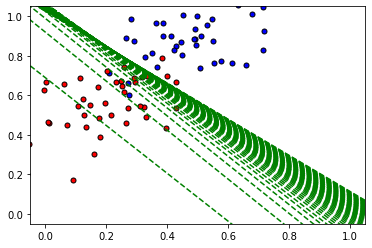

In [150]:
for i , (m,b) in enumerate(weights_and_biases):
    if i%log_interval == 0:
        display(m,b)
plot_points(data.iloc[:,:2].values, data.iloc[:,2].values)
plt.show()

In [112]:
points_nn.l1.weight.data, points_nn.l1.bias.data

(tensor([[-6.9980, -7.1117]]), tensor([7.5623]))